In [1]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import Sequence

In [2]:
class ImageDataGenerator(Sequence):
    def __init__(self, input_dir, output_dir, batch_size, img_height, img_width):
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width
        self.indexes = np.random.permutation(len(os.listdir(input_dir)))

    def __len__(self):
        return len(os.listdir(self.input_dir)) // self.batch_size
    
    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx*self.batch_size : (idx+1)*self.batch_size]
        input_images = []
        output_images = np.zeros((self.batch_size, self.img_height, self.img_width, 1))
        for i, batch_index in enumerate(batch_indexes):
            file_name = os.listdir(self.input_dir)[batch_index]
            if file_name.endswith(('.jpg', '.jpeg')):
                input_path = os.path.join(self.input_dir, file_name)
                output_name = os.path.splitext(file_name)[0] + '.png'
                output_path = os.path.join(self.output_dir, output_name)
                input_image = cv2.imread(input_path)
                output_image = cv2.imread(output_path, cv2.IMREAD_GRAYSCALE)
                input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
                input_image = cv2.resize(input_image, (self.img_height, self.img_width))
                output_image = cv2.resize(output_image, (self.img_height, self.img_width))
                input_image = input_image / 255.0
                output_image = output_image / 255.0
                input_image = np.expand_dims(input_image, axis=0)
                output_image = np.expand_dims(output_image, axis=-1)
                input_images.append(input_image)
                output_images[i] = output_image
        return np.vstack(input_images), output_images

In [3]:
# Set up input image and mask directories
input_dir = '../Orange/bg_remover dataset/train/preproimages/'
output_dir = '../Orange/bg_remover dataset/train/mask maskedimg/'

# Define batch size and image dimensions
batch_size = 32
img_height = 256
img_width = 256

# Create a generator object
train_image_gen = ImageDataGenerator(input_dir, output_dir, batch_size, img_height, img_width)

In [4]:
# Set up input image and mask directories
input_dir = '../Orange/bg_remover dataset/val/preproimages/'
output_dir = '../Orange/bg_remover dataset/val/mask maskedimg/'

# Define batch size and image dimensions
batch_size = 32
img_height = 256
img_width = 256

# Create a generator object
val_image_gen = ImageDataGenerator(input_dir, output_dir, batch_size, img_height, img_width)

(32, 256, 256, 3) float64


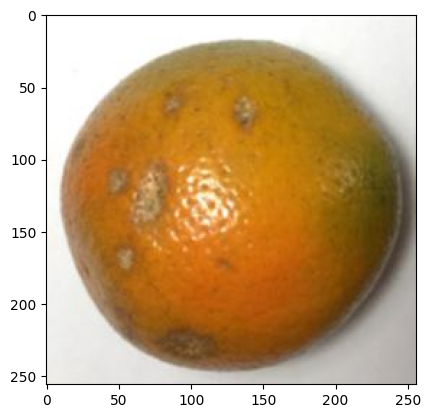

In [5]:
import matplotlib.pyplot as plt

for img,lbl in train_image_gen:
    print(img.shape,img[0].dtype)
    plt.imshow(img[15])
    break

(32, 256, 256, 1) float64


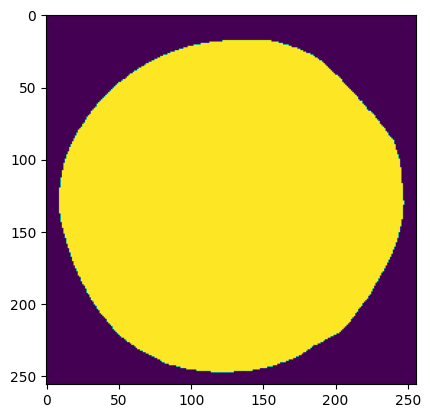

In [6]:
for img,lbl in train_image_gen:
    print(lbl.shape,lbl[0].dtype)
    plt.imshow(lbl[15])
    break

(32, 256, 256, 3) float64


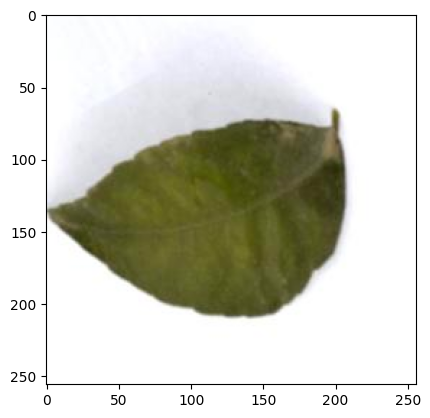

In [7]:
for img,lbl in val_image_gen:
    print(img.shape,img[0].dtype)
    plt.imshow(img[15])
    break

(32, 256, 256, 1) float64


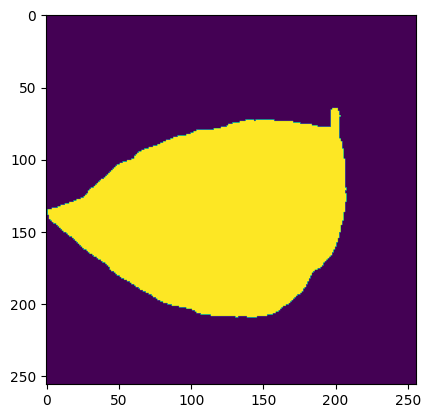

In [8]:
for img,lbl in val_image_gen:
    print(lbl.shape,lbl[0].dtype)
    plt.imshow(lbl[15])
    break

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate

def create_model():
    inputs = tf.keras.Input(shape=(256, 256, 3))
    
    # Encoder
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    
    # Decoder
    up5 = Concatenate()([UpSampling2D((2, 2))(conv4), conv3])
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up5)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)
    up6 = Concatenate()([UpSampling2D((2, 2))(conv5), conv2])
    conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv6)
    up7 = Concatenate()([UpSampling2D((2, 2))(conv6), conv1])
    conv7 = Conv2D(16, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv7)
    
    # Output
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv7)
    
    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

In [10]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras import backend as K

In [11]:
def dice_coefficient(y_true, y_pred):
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

In [12]:
model = create_model()

model.compile(optimizer='adam', loss=binary_crossentropy, metrics=[MeanIoU(num_classes=2), dice_coefficient])

In [13]:
epochs=30
steps_per_epochs=len(train_image_gen)
validation_steps=len(val_image_gen)

print(steps_per_epochs,validation_steps)

160 15


In [14]:
model.fit(train_image_gen,epochs=epochs,batch_size=32,validation_data=val_image_gen,validation_steps=validation_steps)

Epoch 1/30
160/160 [==============================] - 1130s 7s/step - loss: 0.4864 - mean_io_u: 1.0000 - dice_coefficient: 0.6688 - val_loss: 0.4901 - val_mean_io_u: 1.0000 - val_dice_coefficient: 0.6973
Epoch 2/30
160/160 [==============================] - 1178s 7s/step - loss: 0.4400 - mean_io_u: 1.0000 - dice_coefficient: 0.7178 - val_loss: 0.4577 - val_mean_io_u: 1.0000 - val_dice_coefficient: 0.6964
Epoch 3/30
160/160 [==============================] - 1177s 7s/step - loss: 0.4357 - mean_io_u: 1.0000 - dice_coefficient: 0.7215 - val_loss: 0.4560 - val_mean_io_u: 1.0000 - val_dice_coefficient: 0.7001
Epoch 4/30
160/160 [==============================] - 1168s 7s/step - loss: 0.4318 - mean_io_u: 1.0000 - dice_coefficient: 0.7250 - val_loss: 0.4597 - val_mean_io_u: 1.0000 - val_dice_coefficient: 0.7003
Epoch 5/30
160/160 [==============================] - 1100s 7s/step - loss: 0.4283 - mean_io_u: 1.0000 - dice_coefficient: 0.7283 - val_loss: 0.4471 - val_mean_io_u: 1.0000 - val_dice_

In [55]:
# Save the model
model.save('../Models/segment.h5')

In [57]:
import keras

with keras.utils.custom_object_scope({'dice_coefficient': dice_coefficient}):
    loaded_model = keras.models.load_model('../Models/segment.h5')

1/1 [==============================] - 0s 100ms/step


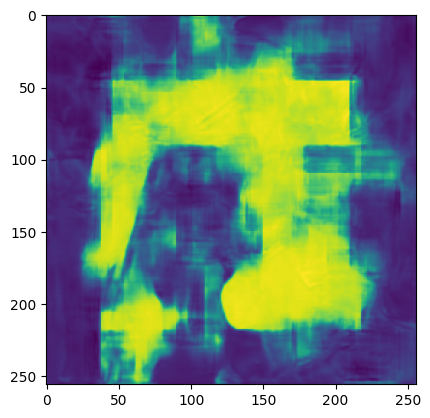

In [229]:
img=cv2.imread("../Orange/bg_remover dataset/train/preproimages/pi (5150).jpg")

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
arr=[(img_rgb/255)]
image=np.array(arr)
# print(image.shape)
output=loaded_model.predict(image)
plt.imshow(output[0])
# plt.imshow(image[0])

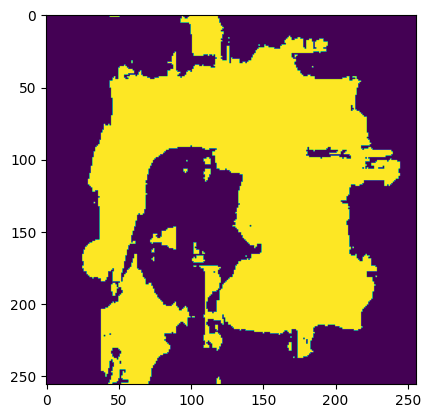

In [230]:
criteria = 0.4  # pixels with values >= criteria will be set to white, otherwise to black
perfect_mask = np.zeros_like(output[0])  # create a new array with the same shape as the distorted mask

for i in range(output[0].shape[0]):
    for j in range(output[0].shape[1]):
        if output[0][i, j] >= criteria:
            perfect_mask[i, j] = 1.0  # set pixel to white
        else:
            perfect_mask[i, j] = 0.0  # set pixel to black

plt.imshow(perfect_mask)

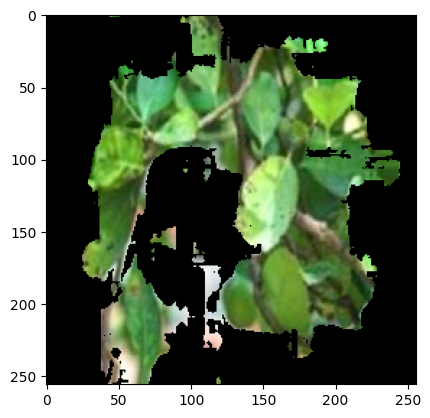

In [231]:
# Repeat the mask along the third axis to create an RGB mask
mask_rgb = np.repeat(perfect_mask[:, :, np.newaxis], 3, axis=2)

# Squeeze the mask_rgb array to remove the extra dimension
mask_rgb = np.squeeze(mask_rgb)

# Apply the mask to the original image
img_foreground = np.multiply(arr[0], mask_rgb)
plt.imshow(img_foreground)

# Save the resulting image as the foreground image
# cv2.imwrite('foreground_image.png', img_foreground)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


class IMAGE_SEGMENTATION:
    
    def __init__(self,image) -> None:
        self.image=image

    def AnalyzeImage(self):
        image=np.array(self.image)
        # print(image.shape)
        output=loaded_model.predict(image)

        criteria = 0.4  # pixels with values >= criteria will be set to white, otherwise to black
        perfect_mask = np.zeros_like(output[0])  # create a new array with the same shape as the distorted mask

        for i in range(output[0].shape[0]):
            for j in range(output[0].shape[1]):
                if output[0][i, j] >= criteria:
                    perfect_mask[i, j] = 1.0  # set pixel to white
                else:
                    perfect_mask[i, j] = 0.0  # set pixel to black


        return perfect_mask

    def Segmentation(self,mask):

        mask_rgb = np.repeat(mask[:, :, np.newaxis], 3, axis=2)

        # Squeeze the mask_rgb array to remove the extra dimension
        mask_rgb = np.squeeze(self.image)

        # Apply the mask to the original image
        img_foreground = np.multiply(self.image, mask_rgb)

        return img_foreground